In [4]:
import pandas as pd

# Load the data
df = pd.read_csv('ecommerce_dataset_updated.csv')

# Use 'dayfirst=True' to fix the ValueError you encountered
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], dayfirst=True)

# Check to make sure it worked
print("Date Conversion Successful!")
print(df['Purchase_Date'].head())

Date Conversion Successful!
0   2024-11-12
1   2024-02-09
2   2024-09-01
3   2024-04-01
4   2024-09-27
Name: Purchase_Date, dtype: datetime64[ns]


In [5]:
# Create a 'snapshot date' to calculate how many days ago they last shopped
# We set this to one day after the very last purchase in the whole dataset
snapshot_date = df['Purchase_Date'].max() + pd.Timedelta(days=1)

# Group data by User_ID to find Recency, Frequency, and Monetary
rfm = df.groupby('User_ID').agg({
    'Purchase_Date': lambda x: (snapshot_date - x.max()).days, # Days since last purchase
    'Product_ID': 'count',                                    # Number of items bought
    'Final_Price(Rs.)': 'sum'                                 # Total money spent
})

# Rename columns so they make sense
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
User_ID,,,
001ae40d,182,1,345.93
0021e458,308,1,123.51
00333c7a,199,1,8.65
00390cf5,135,1,96.32
0041710c,180,1,388.45


In [6]:
# Note: For Recency, 5 is the 'Best' (most recent), so we use labels=[5, 4, 3, 2, 1]
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# For Frequency and Monetary, 5 is the 'Best' (highest amount/count)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine these into a single string like '555' (the perfect customer)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [7]:
def segment_customer(df):
    if df['RFM_Score'].startswith('55'):
        return 'Champions' # Top scores in everything
    elif df['RFM_Score'].startswith('1'):
        return 'At Risk'    # Haven't bought in a long time
    elif df['F_Score'] >= 4:
        return 'Loyal Customers'
    else:
        return 'General'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

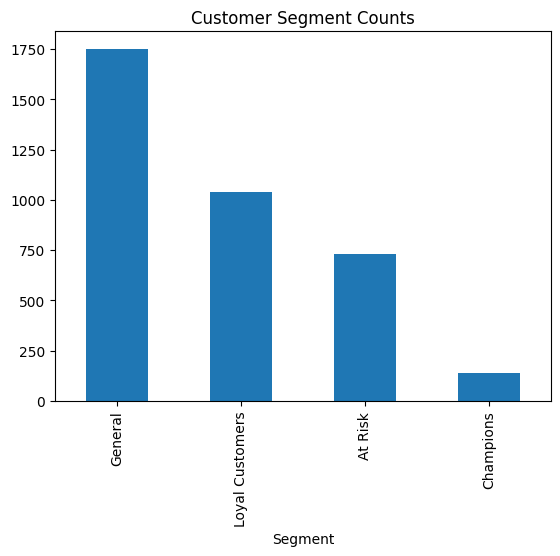

In [8]:
rfm['Segment'].value_counts().plot(kind='bar')
plt.title('Customer Segment Counts')
plt.show()

In [9]:
rfm.to_csv('rfm_segments.csv')